## Time dependent Bayesian Optimization

In this example we demonstrate time dependent optimization. In this case we are not
only interested in finding an optimum point in input space, but also maintain the
ideal point over time.

In [1]:
from xopt.generators.bayesian.upper_confidence_bound import TDUpperConfidenceBoundGenerator
from xopt.vocs import VOCS
from xopt.evaluator import Evaluator
import warnings
warnings.filterwarnings("ignore")

### Time dependent test problem
Optimization is carried out over a single variable `x`. The test function is a simple
 quadratic, with a minimum location that drifts in the positive `x` direction over
 (real) time.

In [2]:
# test evaluate function and vocs
import time
start_time = time.time()
def f(inputs):
    x_ = inputs["x"]
    current_time = time.time()
    t_ = current_time - start_time
    y_ = 5*(x_ - t_*1e-2)**2
    return {"y":y_, "time":current_time}

variables = {"x":[-1,1]}
objectives = {"y": "MINIMIZE"}

vocs = VOCS(variables=variables, objectives=objectives)
print(vocs)

evaluator = Evaluator(function=f)
generator = TDUpperConfidenceBoundGenerator(vocs)
generator.options.n_initial = 3
generator.options.acq.added_time=2.0
generator.options.acq.beta = 2.0
#generator.options.model.use_low_noise_prior = True
generator.options


variables={'x': [-1.0, 1.0]} constraints={} objectives={'y': 'MINIMIZE'} constants={} linked_variables={}


TDUCBOptions(optim=OptimOptions(num_restarts=5, raw_samples=20, sequential=True, use_nearby_initial_points=True, max_travel_distances=None), acq=TDUpperConfidenceBoundOptions(proximal_lengthscales=None, use_transformed_proximal_weights=True, monte_carlo_samples=128, added_time=2.0, beta=2.0), model=TDModelOptions(function=<function create_time_dependent_model at 0x7f0ca835b040>, kwargs=kwargs(use_conservative_prior_lengthscale=False, use_conservative_prior_mean=False, use_low_noise_prior=False)), n_initial=3)

In [3]:
from xopt import Xopt
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

X.step()

for _ in range(20):
    X.step()
    time.sleep(0.1)

print(X.generator.generate(1))

          x
0  0.491743


In [4]:
X.data

,x,y,time,xopt_runtime,xopt_error
1,0.894357,3.817067,1.663864e+09,0.000007,False
2,0.350502,0.544104,1.663864e+09,0.000002,False
3,0.694130,2.268062,1.663864e+09,0.000001,False
4,-0.167291,0.216205,1.663864e+09,0.000007,False
5,-0.911815,4.738563,1.663864e+09,0.000008,False
6,0.460604,0.713966,1.663864e+09,0.000008,False
7,0.029233,0.027775,1.663864e+09,0.000008,False
8,0.285738,0.129502,1.663864e+09,0.000007,False
9,0.008194,0.094730,1.663864e+09,0.000008,False
10,0.230716,0.020379,1.663864e+09,0.000008,False


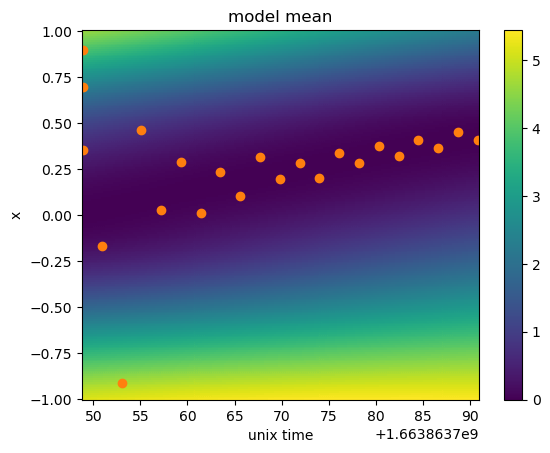

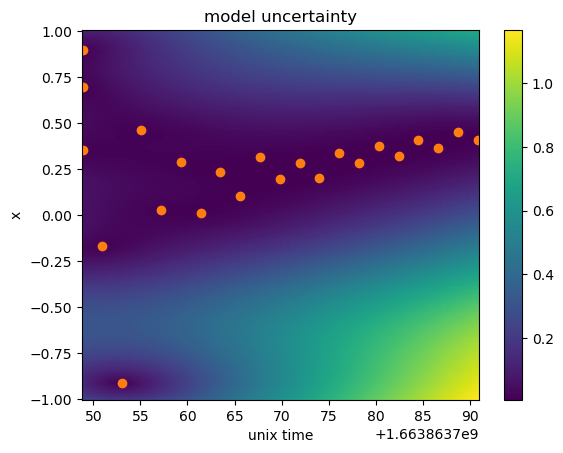

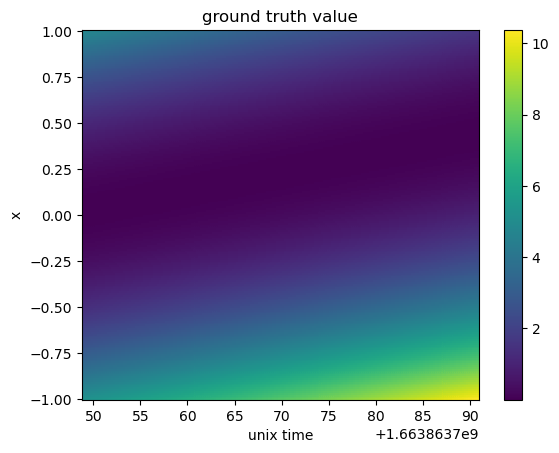

In [5]:
# plot model
import torch
from matplotlib import pyplot as plt  # plot model predictions
data = X.data

xbounds = generator.vocs.bounds
tbounds = [data["time"].min(), data["time"].max()]

def gt(inpts):
    return 5*(inpts[:,1] - (inpts[:,0] - start_time)*1e-2)**2

model = X.generator.model
n = 200
t = torch.linspace(*tbounds, n, dtype=torch.double)
x = torch.linspace(*xbounds.flatten(), n, dtype=torch.double)
tt, xx = torch.meshgrid(t, x)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (tt, xx)]).double()

#NOTE: the model inputs are such that t is the last dimension
gp_pts = torch.flip(pts, dims=[-1])

gt_vals = gt(pts)

with torch.no_grad():
    post = model.posterior(gp_pts)

    mean = post.mean
    std = torch.sqrt(post.variance)

    fig, ax = plt.subplots()
    ax.set_title("model mean")
    ax.set_xlabel("unix time")
    ax.set_ylabel("x")
    c = ax.pcolor(tt, xx, mean.reshape(n,n))
    fig.colorbar(c)

    fig2, ax2 = plt.subplots()
    ax2.set_title("model uncertainty")
    ax2.set_xlabel("unix time")
    ax2.set_ylabel("x")
    c = ax2.pcolor(tt, xx, std.reshape(n,n))
    fig2.colorbar(c)

    ax.plot(data["time"].to_numpy(), data["x"].to_numpy(),"oC1")
    ax2.plot(data["time"].to_numpy(), data["x"].to_numpy(),"oC1")

    fig3, ax3 = plt.subplots()
    ax3.set_title("ground truth value")
    ax3.set_xlabel("unix time")
    ax3.set_ylabel("x")
    c = ax3.pcolor(tt, xx, gt_vals.reshape(n,n))
    fig3.colorbar(c)

In [6]:
list(model.named_parameters())

[('models.0.likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([1.0000e-04], dtype=torch.float64, requires_grad=True)),
 ('models.0.mean_module.raw_constant',
  Parameter containing:
  tensor(3.0796, dtype=torch.float64, requires_grad=True)),
 ('models.0.covar_module.raw_outputscale',
  Parameter containing:
  tensor(3.7827, dtype=torch.float64, requires_grad=True)),
 ('models.0.covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[-0.3493,  1.6486]], dtype=torch.float64, requires_grad=True))]

46.133519649505615


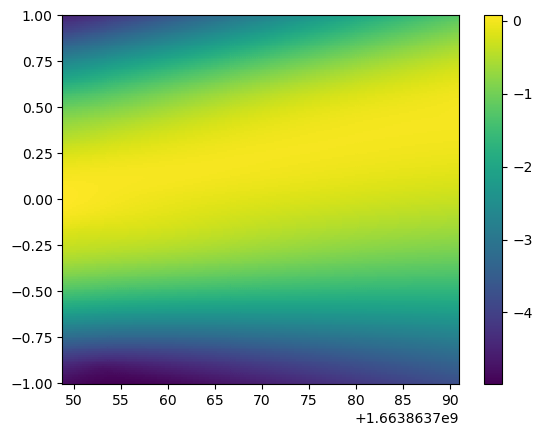

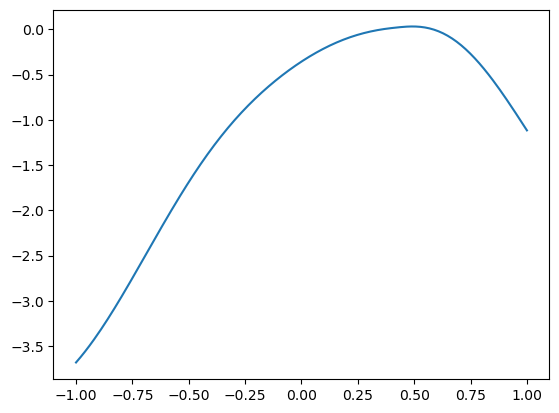

In [7]:
# plot the acquisition function
# note that target time is only updated during the generate call
target_time = generator.target_prediction_time
print(target_time-start_time)
my_acq_func = generator.get_acquisition(model)

with torch.no_grad():
    acq_pts = x.unsqueeze(-1).unsqueeze(-1)
    full_acq = my_acq_func.acq_func(gp_pts.unsqueeze(1))
    fixed_acq = my_acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(tt, xx, full_acq.reshape(n,n))
    fig.colorbar(c)

    fi2, ax2 = plt.subplots()
    ax2.plot(x.flatten(), fixed_acq.flatten())